# Guitar amp simulation

## Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile

In [2]:
samplerate_dry, dry_signal = wavfile.read('Audio files/01_guitar_dry_01_.wav')

samplerate_wet, wet_signal = wavfile.read('Audio files/01_guitar_amped_01_.wav')
wet_signal_mono = wet_signal

### Visualisation

Text(0, 0.5, 'wet signal')

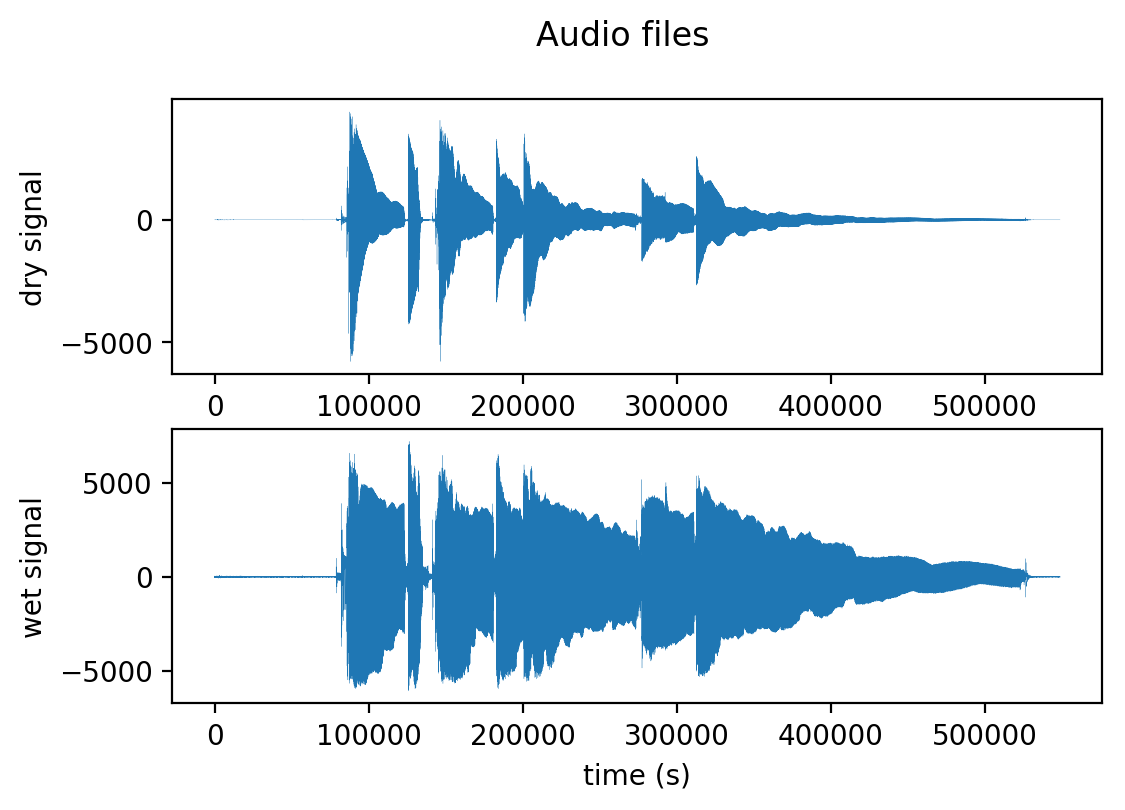

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=200,)
fig.suptitle('Audio files')

ax1.plot(dry_signal,lw=0.1)
ax1.set_ylabel('dry signal')

ax2.plot(wet_signal_mono,lw=0.1)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('wet signal')

### Transformation to frequency

In [4]:
#FFT parameters

# sampling frequency [Hz]
sample_rate = samplerate_dry

# time step [s]
t_step = 1/sample_rate

# buffer size (number of samples)
buffer = 256

# frequency interval [Hz] (in frequency domain)
f_step = sample_rate / buffer

In [5]:
#data transformation - columns represents buffer blocks

dry_buffer = []
wet_buffer = []

for i0 in range(0,len(dry_signal)//buffer):
    
    shift = i0 * buffer
    
    dry_buffer.append(dry_signal[0 + shift : buffer + shift])
    wet_buffer.append(wet_signal_mono[0 + shift : buffer + shift])
    
dry_buffer = np.array(dry_buffer)
wet_buffer = np.array(wet_buffer)

total_buffer = np.append(dry_buffer,wet_buffer,axis=1)

In [6]:
# time --> frequency domain

dry_buffer_fft = []
wet_buffer_fft = []

#freq_samples = int(buffer/2 +1)

for i in range(0,len(dry_buffer)):
    
    fourier_dry = np.fft.rfft(dry_buffer[i,:])
    dry_modulus = np.abs(fourier_dry)
    dry_argument = np.angle(fourier_dry)
    
    total_dry = np.append(dry_modulus,dry_argument)
    
    dry_buffer_fft.append(total_dry)
    
    
    
    fourier_wet = np.fft.rfft(wet_buffer[i,:])
    wet_modulus = np.abs(fourier_wet)
    wet_argument = np.angle(fourier_wet)
    
    total_wet = np.append(wet_modulus,wet_argument)
    
    wet_buffer_fft.append(total_wet)
    
dry_buffer_fft = np.array(dry_buffer_fft)
wet_buffer_fft = np.array(wet_buffer_fft)

## Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [8]:
torch.cuda.is_available()

True

In [9]:
class My_amp(nn.Module):
    def __init__(self, in_features=buffer+2, h1=8192, h2=4096, out_features=buffer+2):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        #self.fc3 = nn.Linear(h2,h3)             # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

In [10]:
torch.manual_seed(101)

model = My_amp()
model = model.cuda() #gpu model

model.load_state_dict(torch.load('my_amp_plexi.pt'))

<All keys matched successfully>

In [11]:
next(model.parameters()).is_cuda

True

## Train/test split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dry_buffer_fft, wet_buffer_fft, test_size=0.3, random_state=42)

In [14]:
X_train = torch.FloatTensor(X_train).cuda()
X_test = torch.FloatTensor(X_test).cuda()
y_train = torch.FloatTensor(y_train).cuda()
y_test = torch.FloatTensor(y_test).cuda()

In [15]:
X_train.shape[0]/8

187.5

## Model training

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [17]:
import time

epochs = 300
losses_train = []
losses_test = []
batches = 8
batch_size = int(X_train.shape[0]/batches)

start_time = time.time()

for i in range(epochs):
    
    i+=1
    
    for b in range(0,batches):
        y_pred = model.forward(X_train[0+int(b*batch_size) : batch_size+int(b*batch_size)])
        loss_train = torch.sqrt(criterion(y_pred, y_train[0+int(b*batch_size) : batch_size+int(b*batch_size)]))
        #losses_train.append(loss_train)

        '''
        with torch.no_grad():
            y_val = model.forward(X_test)
            loss_test = torch.sqrt(criterion(y_val, y_test))
            losses_test.append(loss_test)

        '''

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    
    # a neat trick to save screen space:
    if i%10 == 0:
        print(f'epoch: {i:2}  loss_train: {loss_train.item():10.8f}')
        #print(f'epoch: {i:2}  loss_train: {loss_train.item():10.8f}  loss_test: {loss_test.item():10.8f} time: {stop_time} s')

stop_time = time.time() - start_time

print(f'Total time: {stop_time} s')

epoch: 10  loss_train: 3189.21533203
epoch: 20  loss_train: 3148.47241211
epoch: 30  loss_train: 3116.43188477
epoch: 40  loss_train: 3103.41015625
epoch: 50  loss_train: 3224.36401367
epoch: 60  loss_train: 3069.29370117
epoch: 70  loss_train: 3136.89135742
epoch: 80  loss_train: 3128.90771484
epoch: 90  loss_train: 3333.39160156
epoch: 100  loss_train: 3063.03808594
epoch: 110  loss_train: 2986.66601562
epoch: 120  loss_train: 2933.38623047
epoch: 130  loss_train: 2986.14599609
epoch: 140  loss_train: 2950.92138672
epoch: 150  loss_train: 2896.16479492
epoch: 160  loss_train: 2869.10913086
epoch: 170  loss_train: 2899.51147461
epoch: 180  loss_train: 2849.16455078
epoch: 190  loss_train: 2815.88940430
epoch: 200  loss_train: 2846.27392578
epoch: 210  loss_train: 2773.64062500
epoch: 220  loss_train: 2768.26464844
epoch: 230  loss_train: 2752.30688477
epoch: 240  loss_train: 2811.71215820
epoch: 250  loss_train: 2781.44726562
epoch: 260  loss_train: 2729.57373047
epoch: 270  loss_trai

In [18]:
torch.save(model.state_dict(), 'my_amp_plexi.pt')

## Loss visualization (optional)

In [19]:
'''
plt.plot(range(epochs), losses_train)
plt.plot(range(epochs), losses_test)
plt.ylabel('Loss')
plt.xlabel('epoch');
'''

"\nplt.plot(range(epochs), losses_train)\nplt.plot(range(epochs), losses_test)\nplt.ylabel('Loss')\nplt.xlabel('epoch');\n"

## Model evaluation

In [20]:
'''
# on the test set

with torch.no_grad():

    y_val = model.forward(X_test)
    loss = torch.sqrt(criterion(y_val, y_test))

print(f'{loss:.8f}')
'''

"\n# on the test set\n\nwith torch.no_grad():\n\n    y_val = model.forward(X_test)\n    loss = torch.sqrt(criterion(y_val, y_test))\n\nprint(f'{loss:.8f}')\n"

## Dry singnal -> trained model (frequency domain) -> IFFT (time domain)

In [21]:
#'''
# evaluation on entire data

dry_in = torch.FloatTensor(dry_buffer_fft).cuda()
wet_out = torch.FloatTensor(wet_buffer_fft).cuda()

with torch.no_grad():
    y_val = model.forward(dry_in)
    loss = torch.sqrt(criterion(y_val, wet_out))
    
print(f'{loss:.8f}')



# comlex numbers --> from modulus,argument represenation TO a + j*b

import math
import cmath

my_range = int(buffer/2 + 1)

modulus_buffer = y_val[:,0:my_range]
argument_buffer = y_val[:,129:]

def P2R(radii, angles):
    return radii * cmath.exp(1j*angles)

output_fft = []

for i0 in range(0,len(modulus_buffer)):
    
    out = []
    
    for i1 in range(0,len(modulus_buffer[i0])):
        
        mag = modulus_buffer[i0,i1].item()
        arg = argument_buffer[i0,i1].item()
        out.append(P2R(mag,arg))
        
    output_fft.append(out)
    
output_fft = np.array(output_fft)



# dry signal processed through trained model - from frequency to time domain transformation

processed_signal = np.fft.irfft(output_fft)
processed_signal = np.array(processed_signal)
processed_signal = processed_signal.flatten()

#'''

3984.26733398


### Visualization (processed vs wet signal)

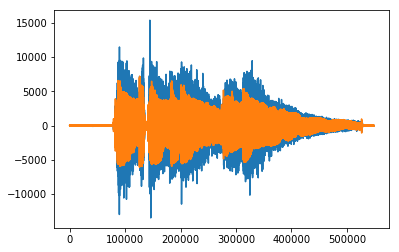

In [22]:
plt.plot(processed_signal)
plt.plot(wet_signal)

In [24]:
wavfile.write('test.wav',48000,processed_signal)